### 17-2. Overall sturcture of OCR

### 17-3. Dataset for OCR

### 17-4. Recognition model

### 17-5. Recognition model (2) Input Image

### 17-6. Recognition model (3) Encode

### 17-7. Recognition model (4) Build CRNN model

### 17-8. Recognition model (5) Train & Inference

**데이터 준비**

In [1]:
import os

path = os.path.join(os.getenv('HOME'),'aiffel/ocr')
os.chdir(path)

print(path)

/aiffel/aiffel/ocr


In [2]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


In [3]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr/data/MJ/MJ_train


**Recognition model (2) Input Image**

데이터셋 안에 들어있는 이미지가 실제로 어떻게 생겼는지 확인해 보자. 아래의 코드를 실행해 lmdb를 통해 훈련데이터셋의 이미지를 4개만 열어서 실제 shape가 어떻게 생겼는지, 이미지나 라벨은 어떻게 달려 있는지를 확인해 보자.

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


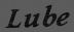

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


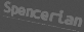

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


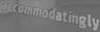

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


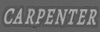

In [4]:
from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
# LMDB 데이터베이스를 열고 읽기 모드로 설정
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
# LMDB 트랜잭션을 열어서 데이터에 접근
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # 인덱스를 이용하여 1부터 4까지의 데이터를 읽어옴
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        # 라벨 키와 이미지 키 생성
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        # 이미지 데이터를 BytesIO 버퍼에 씀
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            # BytesIO에서 이미지를 읽어옴
            img = Image.open(buf).convert('RGB')

        except IOError:
            # 이미지 읽기 실패 시 빈 이미지 생성
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

이제부터 lmdb를 활용하여 케라스 모델 학습용 MJSynth데이터셋 클래스를 구현하려고 한다. dataset_path는 읽어들일 데이터셋의 경로이다. label_converter는 아래에서 여러분이 문자를 미리정의된 index로 변환해주는 converter로 직접 구현하도록 한다. 이외에도 batch_size와 입력이미지 크기 그리고 필터링을 위한 최대 글자 수, 학습대상으로 한정하기 위한 character등을 입력으로 받도록 구현되어 있다.

In [5]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        # 라벨 변환기, 배치 크기, 이미지 크기, 최대 텍스트 길이 등을 초기화
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        # LMDB 환경 설정
        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            # 데이터 샘플 수와 인덱스 리스트 초기화
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        # 데이터셋의 총 배치 수 계산
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        # LMDB에서 이미지와 라벨을 읽어오는 메서드
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
         # 데이터를 배치 단위로 읽어오는 메서드
        
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

print("슝~")

슝~


위의 분석코드처럼 이미지 데이터를 img, label의 쌍으로 가져오는 부분은 _get_img_label() 메소드에 반영되었다. 그리고 model.fit()에서 호출되는 __getitem__() 메소드에서 배치 단위만큼 _get_img_label() 를 통해 가져온 데이터셋을 리턴하게 된다. _get_img_label() 를 보면 다양한 사이즈의 이미지를 모두 height는 32로 맞추고, width는 최대 100까지로 맞추게끔 가공하고 있다.

**Recognition model (3) Encode**

이전 스텝에서 살펴본 바에 의하면, Label이 우리가 읽을 수 있는 평문 Text로 이루어져 있었다. 그러나 이것은 모델을 학습하기 위해서 적절한 형태가 아니다. 따라서 각 Character를 class로 생각하고 이를 step에 따른 class index로 변환해서 encode를 해주어야 한다. 이를 해줄 수 있는 LabelConverter 클래스를 작성해 보자.

- __init__()에서는 입력으로 받은 text를 self.dict에 각 character들이 어떤 index에 매핑되는지 저장합니다. 이 character와 index 정보를 통해 모델이 학습할 수 있는 output이 만들어집니다. 만약 character='ABCD'라면 'A'의 label은 1, 'B'의 label은 2가 됩니다.

- 공백(blank) 문자를 지정합니다. 여기서는 공백 문자를 뜻하기 위해 '-'를 활용하며, label은 0으로 지정합니다.

- decode()는 각 index를 다시 character로 변환한 후 이어주어 우리가 읽을 수 있는 text로 바꾸어줍니다.
        
        입력받은 text를 모델이 학습할 수 있는 label로 만드는 encode() 메소드를 구현해 주세요!
        
        단, 같은 글자가 연속으로 이어지는 경우에는 이어지는 그 사이에 공백 문자의 label을 포함해야 합니다!

OCR 모델 학습데이터에 왜 공백 문자가 포함되어야 하는지는 다음 스텝에서 설명할 예정입니다.

In [6]:
class LabelConverter(object):

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         for i, char in enumerate(text):
             if i > 0 and char == text[i - 1]:
                 encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
             encoded_label.append(self.label_map[char])

         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label

아래에서 'HELLO'를 Encode한 후 Decode가 정상적으로 되는지 확인해보도록 해보자

In [7]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


**Recognition model (4) Build CRNN model**

이제 입력과 출력을 준비했으니 모델을 만들어보자. Keras에서 제공하는 K.ctc_batch_cost()를 활용해서 loss를 계산하도록 ctc_lambda_func를 아래와 같이 만들어준다.

In [8]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
print("슝~")

슝~


여기서 잠시 Keras의 K.ctc_batch_cost() 함수에 대해 짚고 넘어가보자. 비록 우리가 이 함수 내부를 직접 구현하진 않겠지만 CTC Loss 함수를 구현하기 위해 우리가 이 함수에 인자로 어떤 값을 넘겨야 하는지는 명확하게 파악해야한다.

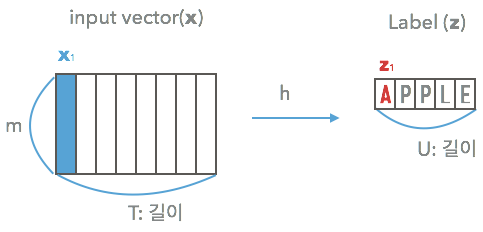

우리는 CTC Loss를 활용해야 하는 모델이 위 그림과 같은 상황을 다루기 위한 것임을 알고 있다. 입력의 길이 T와 라벨의 길이 U의 단위가 일치하지 않을 때, 그래서 라벨은 APPLE이지만 모델이 출력한 결과는 AAAPPPPLLLLEE 처럼 나올 수 있다. 이런 상황이 이미지에서 텍스트 라벨을 추론해야 하는 Text recognition 태스크에 동일하게 적용된다.

        만약 모델이 AAAPPPPLLLLEE을 출력했다고 하자. 이때 추론 결과는 APLE일지 APPLE일지 구분이 가능할까? 이 경우에는 APLE로 결론을 내리게 될 것이다.

        그러므로 추론 결과가 APPLE이 되게 하려면 이미지의 라벨은 AP-PLE로 보정해 주어야 한다. 그래서 모델이 AAAPP-PPLLLEE로 출력을 한다면 추론 결과는 APPLE이 되는 것이다. 이런 이유로 이전 스텝에서 LabelConverter.encode() 메소드에 공백문자 처리로직을 포함했던 것이다.

위 텐서플로우 튜토리얼에 따르면, K.ctc_batch_cost(y_true, y_pred, input_length, label_length)에는 4가지 인자가 존재한다. 각각의 인자의 의미는 다음과 같다.

- y_true: tensor (samples, max_string_length) containing the truth labels.
- y_pred: tensor (samples, time_steps, num_categories) containing the prediction, or output of the softmax.
- input_length tensor: (samples, 1) containing the sequence length for each batch item in y_pred.
- label_length tensor: (samples, 1) containing the sequence length for each batch item in y_true.
(여기서 samples는 배치사이즈를 의미)

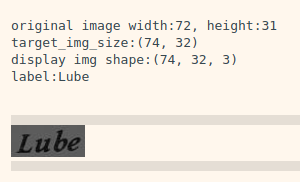

위 그림은 이전 스텝에서 살펴본 실제 데이터셋 예시이다. 이 케이스를 예로 들었을 때 위 인자들은 다음과 같이 될 것이다.

- y_true: 실제 라벨 LUBE. 텍스트 라벨 그대로가 아니라, 각 글자를 One-hot 인코딩한 형태로서, max_string_length 값은 모델에서 22로 지정할 예정
- y_pred: 우리가 만들 RCNN 모델의 출력 결과. 길이는 4가 아니라 우리가 만들 RNN의 최종 출력 길이로서 24가 될 예정
- input_length tensor: 모델 입력 길이 T로서, 이 경우에는 텍스트의 width인 74
- label_length tensor: 라벨의 실제 정답 길이 U로서, 이 경우에는 4
***
이제, K.ctc_batch_cost()를 활용하여, image_input을 입력으로, 마지막 Label을 'output'이라는 이름으로 출력하는 레이어를 갖도록 모델을 만드는 함수 build_crnn_model()을 구현해 보자.

In [9]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    # 출력 레이어의 클래스 수는 문자의 수와 마지막에 CTC에서 사용되는 'start'와 'end' 토큰의 2개가 추가된 값
    num_chars = len(characters)+2
    
    # 입력 이미지의 shape 및 데이터 타입을 정의
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    
    # 특징 추출
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    
    # 시퀀스 입력에 맞게 형태 재구성
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    
    # 완전 연결 레이어
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    
    # 양방향 LSTM 레이어
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    
    # 소프트맥스 활성화 함수를 사용한 출력 레이어
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    # 라벨, 입력 길이, 라벨 길이를 위한 입력 레이어 정의
    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    
    # 람다 함수를 사용하여 CTC 손실 레이어 정의
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    
    # 모델의 입력 및 출력 정의
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model
print("슝~")

슝~


**Recognition model (5) Train & Inference**

이제 앞에서 정의한 MJDatasetSequence로 데이터를 적절히 분리하여 구성된 데이터셋을 통해 학습을 시켜보자.

In [10]:
# 데이터셋과 모델을 준비합니다
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [11]:
# 훈련이 빨리 끝날 수 있도록 ModelCheckPoint와 EarlyStopping을 사용합니다
# ModelCheckPoint의 경우 'val_loss'를 모니터링하고 weight만 저장하는 옵션으로 지정해주세요.
# EarlyStopping도 'val_loss'를 모니터링해주세요.
# (EarlyStopping을 사용하지 않는 경우, model.fit()의 epoch 옵션을 20 정도로 설정해주세요.

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_path = HOME_DIR + '/model_checkpoint_2.hdf5'

ckp = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_weights_only=True, save_best_only=True, mode='min')

# earlystop = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)

history = model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=7,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks = ckp
#           callbacks=[ckp, earlystop]
)

Epoch 1/7
565/565 [==============================] - 96s 149ms/step - loss: 25.6383 - val_loss: 23.9461
Epoch 2/7
565/565 [==============================] - 82s 146ms/step - loss: 16.9661 - val_loss: 11.2083
Epoch 3/7
565/565 [==============================] - 82s 145ms/step - loss: 8.0013 - val_loss: 7.0112
Epoch 4/7
565/565 [==============================] - 82s 145ms/step - loss: 5.6070 - val_loss: 5.6690
Epoch 5/7
565/565 [==============================] - 82s 146ms/step - loss: 4.4059 - val_loss: 4.9017
Epoch 6/7
565/565 [==============================] - 82s 146ms/step - loss: 3.5941 - val_loss: 4.6311
Epoch 7/7
565/565 [==============================] - 82s 145ms/step - loss: 2.9755 - val_loss: 4.3582


/tmp/ipykernel_881/1859285566.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, "b", label="Validation loss", color = 'red')


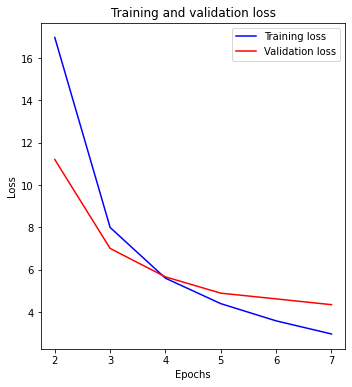

In [12]:
import matplotlib.pyplot as plt

# 손실 그래프
epochs = range(2, len(history.history["loss"]) + 1)
loss = history.history["loss"][1:] # 1의 손실 함수가 너무 커서 제외
val_loss = history.history["val_loss"][1:]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss", color = 'red')
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

이제 학습된 모델을 테스트셋을 통해 확인해 볼 차례입니다.

**직접 학습시킨 모델 사용**

In [91]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = HOME_DIR + '/model_checkpoint_2.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

[19 12  9 14 11  9 14  7 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Result: 	 SLINKING9999999999999999


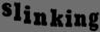

[ 1 12  5 16  0 16 15 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Result: 	 ALEPPO99999999999999999


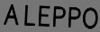

[ 9 23  1 14  4  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Result: 	 IWANDA999999999999999999


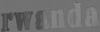

[14  1 20  8  1 14 19 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Result: 	 NATHANS99999999999999999


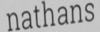

[ 8  1 12 15 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Result: 	 HALO99999999999999999999


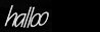

[ 8 21 18 12 19 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Result: 	 HURLS9999999999999999999


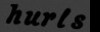

[ 4 15 23 14 19  9 26  5 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Result: 	 DOWNSIZE9999999999999999


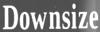

[18 15  2 15 20  9  3 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Result: 	 ROBOTIC99999999999999999


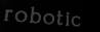

[19 12 15 16  0 16 25 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Result: 	 SLOPPY99999999999999999


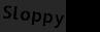

[ 8  5 18 13  9 20  5 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Result: 	 HERMITE99999999999999999


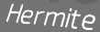

In [92]:
check_inference(model_pred, test_set, index=10)

**미리 학습된 모델 사용**

In [93]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = HOME_DIR + '/data/model_checkpoint.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

[19 12  9 14 11  9 14  7 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Result: 	 SLINKING9999999999999999


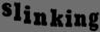

[ 1 12  5 16  0 16 15 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Result: 	 ALEPPO99999999999999999


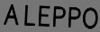

[ 6 23  1 14  4  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Result: 	 FWANDA999999999999999999


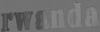

[14  1 20  8  1 14 19 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Result: 	 NATHANS99999999999999999


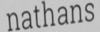

[ 8  1 12  0 12  5 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Result: 	 HALLE999999999999999999


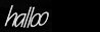

[ 8 21 18 12 19 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Result: 	 HURLS9999999999999999999


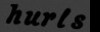

[ 4 15 23 14 19  9 26  5 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Result: 	 DOWNSIZE9999999999999999


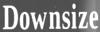

[18 15  2 15 20  9  3 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Result: 	 ROBOTIC99999999999999999


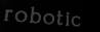

[19 12 15 16  0 16 25 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Result: 	 SLOPPY99999999999999999


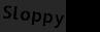

[19  8  5 18 13  9 20  5 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Result: 	 SHERMITE9999999999999999


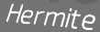

In [94]:
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다

# 모델이 inference한 결과를 글자로 디코딩하는 역할을 하는 함수
# CTC 디코딩 결과를 추출하여 문자열로 변환합니다
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    
    # CTC 디코딩 결과를 얻기 위해 K.ctc_decode 함수를 사용
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    
    # 디코딩된 인덱스를 문자열로 변환
    text = ""
    print(indexes)
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        # 데이터셋으로부터 입력과 출력을 가져옴
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        
        # 모델에 입력 이미지를 주어 예측 수행
        output = model.predict(img)
        
        # CTC 디코딩 결과를 문자열로 변환하여 출력
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

# 예측 모델(model_pred)과 테스트 데이터셋(test_set)을 사용하여
# check_inference 함수를 호출하고 결과를 출력하는 코드
check_inference(model_pred, test_set, index=10)

In [95]:
import tensorflow as tf
import numpy as np
import PIL
import cv2
import keras_ocr

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(cv2.__version__)
print(keras_ocr.__version__)

2.6.0
1.21.4
8.3.2
4.5.3
0.8.8


In [96]:
from keras_ocr.detection import Detector

SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


이미지 경로를 받아 해당 이미지 내의 문자를 찾아내는 함수를 keras-ocr의 Detector를 이용해서 만들어보자! inference한 후에는 이를 시각화하도록 하자. 단어의 영역을 잘라오도록 해.

In [97]:
import cv2
import tensorflow as tf
from keras_ocr.detection import Detector
from PIL import ImageDraw

# 이미지에서 텍스트를 검출하는 함수
def detect_text(img_path):
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print('img')
    print(img)
    print('img.shape')
    print(img.shape)
    result_img = img.copy()
    
    # 배치 크기를 위해서 dimension을 확장해주고 kera-ocr의 입력 차원에 맞게 H,W,C로 변경합니다.
    input_img = img[tf.newaxis, ...]
    print('input_img')
    print(input_img)
    print('input_img.shape')
    print(input_img.shape)
    # 배치의 첫 번째 결과만 가져옵니다.
    result = detector.detect(input_img)
    print('result')
    print(result)
    ocr_result = result[0]
    print('ocr_result')
    print(ocr_result)
    # 시각화를 위해서 x와 y좌표를 변경해줍니다. (앞선 h dimension으로 인해 y,x로 표기됨)
    img_pil = Image.fromarray(result_img)
    img_draw = ImageDraw.Draw(img_pil)
    
    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))


    return result_img, cropped_imgs

In [98]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
print('img_pil')
display(img_pil)

img
[[[213 214 209]
  [210 211 206]
  [206 207 202]
  ...
  [187 182 178]
  [187 182 178]
  [190 185 181]]

 [[188 189 184]
  [187 188 183]
  [185 186 181]
  ...
  [187 182 178]
  [186 181 177]
  [187 182 178]]

 [[175 176 171]
  [175 176 171]
  [176 177 172]
  ...
  [188 183 179]
  [189 184 180]
  [192 187 183]]

 ...

 [[ 60  77 103]
  [ 62  79 105]
  [ 63  80 106]
  ...
  [ 56  73 101]
  [ 57  74 102]
  [ 57  74 102]]

 [[ 61  78 104]
  [ 62  79 105]
  [ 64  81 107]
  ...
  [ 57  74 102]
  [ 58  75 103]
  [ 58  75 103]]

 [[ 60  77 103]
  [ 62  79 105]
  [ 64  81 107]
  ...
  [ 57  74 102]
  [ 58  75 103]
  [ 59  76 104]]]
img.shape
(900, 1200, 3)
input_img
[[[[213 214 209]
   [210 211 206]
   [206 207 202]
   ...
   [187 182 178]
   [187 182 178]
   [190 185 181]]

  [[188 189 184]
   [187 188 183]
   [185 186 181]
   ...
   [187 182 178]
   [186 181 177]
   [187 182 178]]

  [[175 176 171]
   [175 176 171]
   [176 177 172]
   ...
   [188 183 179]
   [189 184 180]
   [192 187 183]]

array([[[213, 214, 209],
        [210, 211, 206],
        [206, 207, 202],
        ...,
        [187, 182, 178],
        [187, 182, 178],
        [190, 185, 181]],

       [[188, 189, 184],
        [187, 188, 183],
        [185, 186, 181],
        ...,
        [187, 182, 178],
        [186, 181, 177],
        [187, 182, 178]],

       [[175, 176, 171],
        [175, 176, 171],
        [176, 177, 172],
        ...,
        [188, 183, 179],
        [189, 184, 180],
        [192, 187, 183]],

       ...,

       [[ 60,  77, 103],
        [ 62,  79, 105],
        [ 63,  80, 106],
        ...,
        [ 56,  73, 101],
        [ 57,  74, 102],
        [ 57,  74, 102]],

       [[ 61,  78, 104],
        [ 62,  79, 105],
        [ 64,  81, 107],
        ...,
        [ 57,  74, 102],
        [ 58,  75, 103],
        [ 58,  75, 103]],

       [[ 60,  77, 103],
        [ 62,  79, 105],
        [ 64,  81, 107],
        ...,
        [ 57,  74, 102],
        [ 58,  75, 103],
        [ 59,  76, 104]]

In [99]:
display(cropped_img)

[<PIL.Image.Image image mode=RGB size=461x196 at 0x7F05CE83AD60>,
 <PIL.Image.Image image mode=RGB size=446x186 at 0x7EF99D94D940>]

In [100]:
img_pil.shape

(900, 1200, 3)

In [101]:
cropped_img[0].size

(461, 196)

In [102]:
cropped_img[1].size

(446, 186)

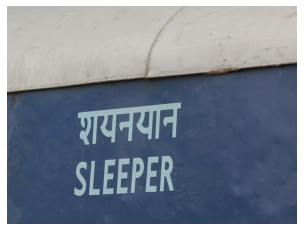

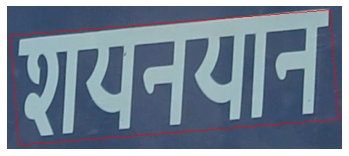

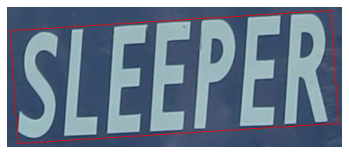

In [103]:
import matplotlib.pyplot as plt

# 이미지를 시각화
plt.imshow(img_pil)  
plt.axis('off')
plt.show()

import matplotlib.pyplot as plt

# 이미지를 시각화
plt.imshow(cropped_img[0])  
plt.axis('off')
plt.show()

import matplotlib.pyplot as plt

# 이미지를 시각화
plt.imshow(cropped_img[1])  
plt.axis('off')
plt.show()


이제 위에서 이미지 내의 단어 이미지를 얻었다. 그럼 Recognition model로 인식하는 함수를 직접 작성하고 그 결과를 출력해보자!

**미리 학습 시킨 모델 사용**

In [104]:
def recognize_img(pil_img, input_img_size=(100, 32)):
    # PIL 이미지를 NumPy 배열로 변환
    img_array = np.array(pil_img)

    # 이미지를 90도 반시계방향으로 회전
    img90 = cv2.rotate(img_array, cv2.ROTATE_90_COUNTERCLOCKWISE)
    # 이미지를 상하로 뒤집음
    img_flip = cv2.flip(img90, 0)

    # 이미지를 모델에 입력할 수 있는 크기로 조정
    pil_img_resized = cv2.resize(img_flip, (input_img_size[1], input_img_size[0]), interpolation=cv2.INTER_CUBIC)
    
    # 모델에 입력할 수 있는 형태로 변환
    img_array_resized = pil_img_resized.reshape(1, *input_img_size, 3)
    
    # 모델로부터 예측 수행
    output = model_pred.predict(img_array_resized)
    
    # CTC 디코딩을 통한 텍스트 추출
    result = decode_predict_ctc(output, chars="-" + TARGET_CHARACTERS)[0].replace('-', '')
    
    # 인식된 단어 출력
    print("Recognized Word: \t", result)
    
    # 인식된 단어 이미지 시각화
    display(Image.fromarray(pil_img_resized.transpose(1, 0, 2).astype(np.uint8)))


[ 3 19 18  4 18 25  9  7  5 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Recognized Word: 	 CSRDRYIGE999999999999999


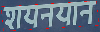

[19 12  5  0  5 16  5 18  5 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Recognized Word: 	 SLEEPERE999999999999999


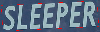

In [105]:
for _img in cropped_img:
    recognize_img(_img)

SLEEPER 뒤에 E 잘못 인식하고 있다.

**직접 학습 시킨 모델**

In [106]:
checkpoint_path = HOME_DIR + '/model_checkpoint_2.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

In [107]:
def recognize_img(pil_img, input_img_size=(100, 32)):
    # PIL 이미지를 NumPy 배열로 변환
    img_array = np.array(pil_img)

    # 이미지를 90도 반시계방향으로 회전
    img90 = cv2.rotate(img_array, cv2.ROTATE_90_COUNTERCLOCKWISE)
    # 이미지를 상하로 뒤집음
    img_flip = cv2.flip(img90, 0)

    # 이미지를 모델에 입력할 수 있는 크기로 조정
    pil_img_resized = cv2.resize(img_flip, (input_img_size[1], input_img_size[0]), interpolation=cv2.INTER_CUBIC)
    
    # 모델에 입력할 수 있는 형태로 변환
    img_array_resized = pil_img_resized.reshape(1, *input_img_size, 3)
    
    # 모델로부터 예측 수행
    output = model_pred.predict(img_array_resized)
    
    # CTC 디코딩을 통한 텍스트 추출
    result = decode_predict_ctc(output, chars="-" + TARGET_CHARACTERS)[0].replace('-', '')
    
    # 인식된 단어 출력
    print("Recognized Word: \t", result)
    
    # 인식된 단어 이미지 시각화
    display(Image.fromarray(pil_img_resized.transpose(1, 0, 2).astype(np.uint8)))



[11 20 18  1  9  5 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Recognized Word: 	 KTRAIE999999999999999999


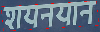

[19 12  5  0  5 16  5 18 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Recognized Word: 	 SLEEPER9999999999999999


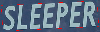

In [108]:
for _img in cropped_img:
    recognize_img(_img)

SLEEPER도 잘 인식하고,

성능이 더 좋아보인다.

## 회고

새롭게 OCR의 개념에 대해 배울 수 있어서 흥미로웠다. 개념을 이해하는데 어려움이 있었다.
CRNN에 대한 흐름은 어느정도 이해된 것 같은데 코드가 왜 이렇게 구현되는지 어려운 부분들이 꽤 있는 것 같다.
좀 더 공부해보며 익혀야할 것 같다.